In [1]:
import numpy as np
import pandas as pd
import os
## 忽略警告
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
read_path="data/test_data/"
file_list = os.listdir(read_path)

file_list.sort()
# file_list = file_list[:1]
# 创建一个空字典
data_dict = {}
column_mapping = {
'数据时间': 'time',
'车速': 'vehicle_speed',
'车辆状态': 'vehicle_status',
'充电状态': 'charge_status',
'累计里程': 'mileage',
'总电压': 'total_voltage',
'总电流': 'total_current',
'SOC': 'soc',
'电池单体电压最高值': 'max_single_cell_voltage',
'电池单体电压最低值': 'min_single_cell_voltage',
'最高温度值': 'max_temperature',
'最低温度值': 'min_temperature',
'驱动电机控制器温度': 'drive_motor_controller_temperature',
'驱动电机转速': 'drive_motor_speed',
'驱动电机转矩': 'drive_motor_torque',
'驱动电机温度': 'drive_motor_temperature',
'电机控制器输入电压': 'motor_controller_input_voltage',
'电机控制器直流母线电流': 'motor_controller_dc_bus_current',
'可充电储能装置电流': 'rechargeable_energy_storage_device_current'
}
feature_columns = ['vehicle_speed', 'vehicle_status', 'charge_status', 'mileage',
    'total_voltage', 'total_current', 'soc',
    'max_single_cell_voltage', 'min_single_cell_voltage', 'max_temperature',
    'min_temperature', 'drive_motor_controller_temperature',
    'drive_motor_speed', 'drive_motor_torque', 'drive_motor_temperature',
    'motor_controller_input_voltage', 'motor_controller_dc_bus_current',
    'rechargeable_energy_storage_device_current']
    
# 循环遍历所有文件
for file_name in file_list:
    # 读取数据集
    dispose_path = os.path.join(read_path , file_name)
    #读取所有子表格的数据然后合并
    data_1 = pd.read_excel(dispose_path, sheet_name=0, index_col=0)
    data_2 = pd.read_excel(dispose_path, sheet_name=1, index_col=0)
    data_3 = pd.read_excel(dispose_path, sheet_name=2, index_col=0)['可充电储能装置电流']
    # 合并数据，根据data_1的索引进行合并
    data = pd.concat([data_1, data_2, data_3], axis=1).loc[data_1.index,:]
    print("正在处理文件：{}".format(dispose_path))
    # 根据文件名和 CLX 字段确定车辆编号
    car_id = file_name.split('_')[0]
    # 修改列名
    data = data.rename(columns=column_mapping)


    ## 填充 nan 值
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)

    # 如果该车辆的数据在字典中已存在，则将新的数据添加到其中
    if car_id in data_dict:
        data_dict[car_id] = pd.concat([data_dict[car_id], data])
    # 如果该车辆的数据不存在，则将新的数据添加为一个新的 DataFrame
    else:
        data_dict[car_id] = data


正在处理文件：data/test_data/CL20_20220401000000_20220430235959.xlsx
正在处理文件：data/test_data/CL20_20220501000000_20220531235959.xlsx
正在处理文件：data/test_data/CL20_20220601000000_20220630235959.xlsx
正在处理文件：data/test_data/CL20_20220701000000_20220731235959.xlsx
正在处理文件：data/test_data/CL20_20220801000000_20220831235959.xlsx
正在处理文件：data/test_data/CL20_20220901000000_20220930235959.xlsx
正在处理文件：data/test_data/CL21_20220401000000_20220430235959.xlsx
正在处理文件：data/test_data/CL21_20220501000000_20220531235959.xlsx
正在处理文件：data/test_data/CL21_20220601000000_20220630235959.xlsx
正在处理文件：data/test_data/CL21_20220701000000_20220731235959.xlsx
正在处理文件：data/test_data/CL21_20220801000000_20220831235959.xlsx
正在处理文件：data/test_data/CL21_20220901000000_20220930235959.xlsx
正在处理文件：data/test_data/CL22_20220401000000_20220430235959.xlsx
正在处理文件：data/test_data/CL22_20220501000000_20220531235959.xlsx
正在处理文件：data/test_data/CL22_20220601000000_20220630235959.xlsx
正在处理文件：data/test_data/CL22_20220701000000_20220731235959.xlsx
正在处理文件：d

车辆CL20，充电能量为:[63.49333333333334, 61.55666666666667, 62.49611111111114, 60.25277777777778, 55.642222222222244, 59.45277777777778, 59.405555555555544, 65.43277777777777, 64.03555555555556, 55.14333333333334, 60.114999999999995, 55.64555555555556, 63.32444444444445, 55.349999999999994, 56.0, 56.23666666666667, 59.03666666666667, 57.9988888888889, 63.99722222222223, 57.230555555555554, 55.11055555555556, 62.711111111111116, 57.32444444444443, 63.72555555555555, 63.15999999999999, 61.08111111111111, 62.981111111111105, 59.08444444444444, 62.27555555555556, 58.61277777777779, 57.7211111111111, 60.80055555555556, 54.98833333333334, 55.28666666666666, 58.22333333333333, 55.45111111111112, 54.302222222222234, 61.16166666666667, 60.28611111111111, 60.156666666666666, 58.06444444444446, 56.29, 56.526666666666664, 56.464999999999996, 55.733888888888906, 58.919999999999995, 63.647222222222226, 56.9538888888889, 63.77055555555556, 55.760555555555555, 55.339444444444446, 57.233333333333334, 57.396111

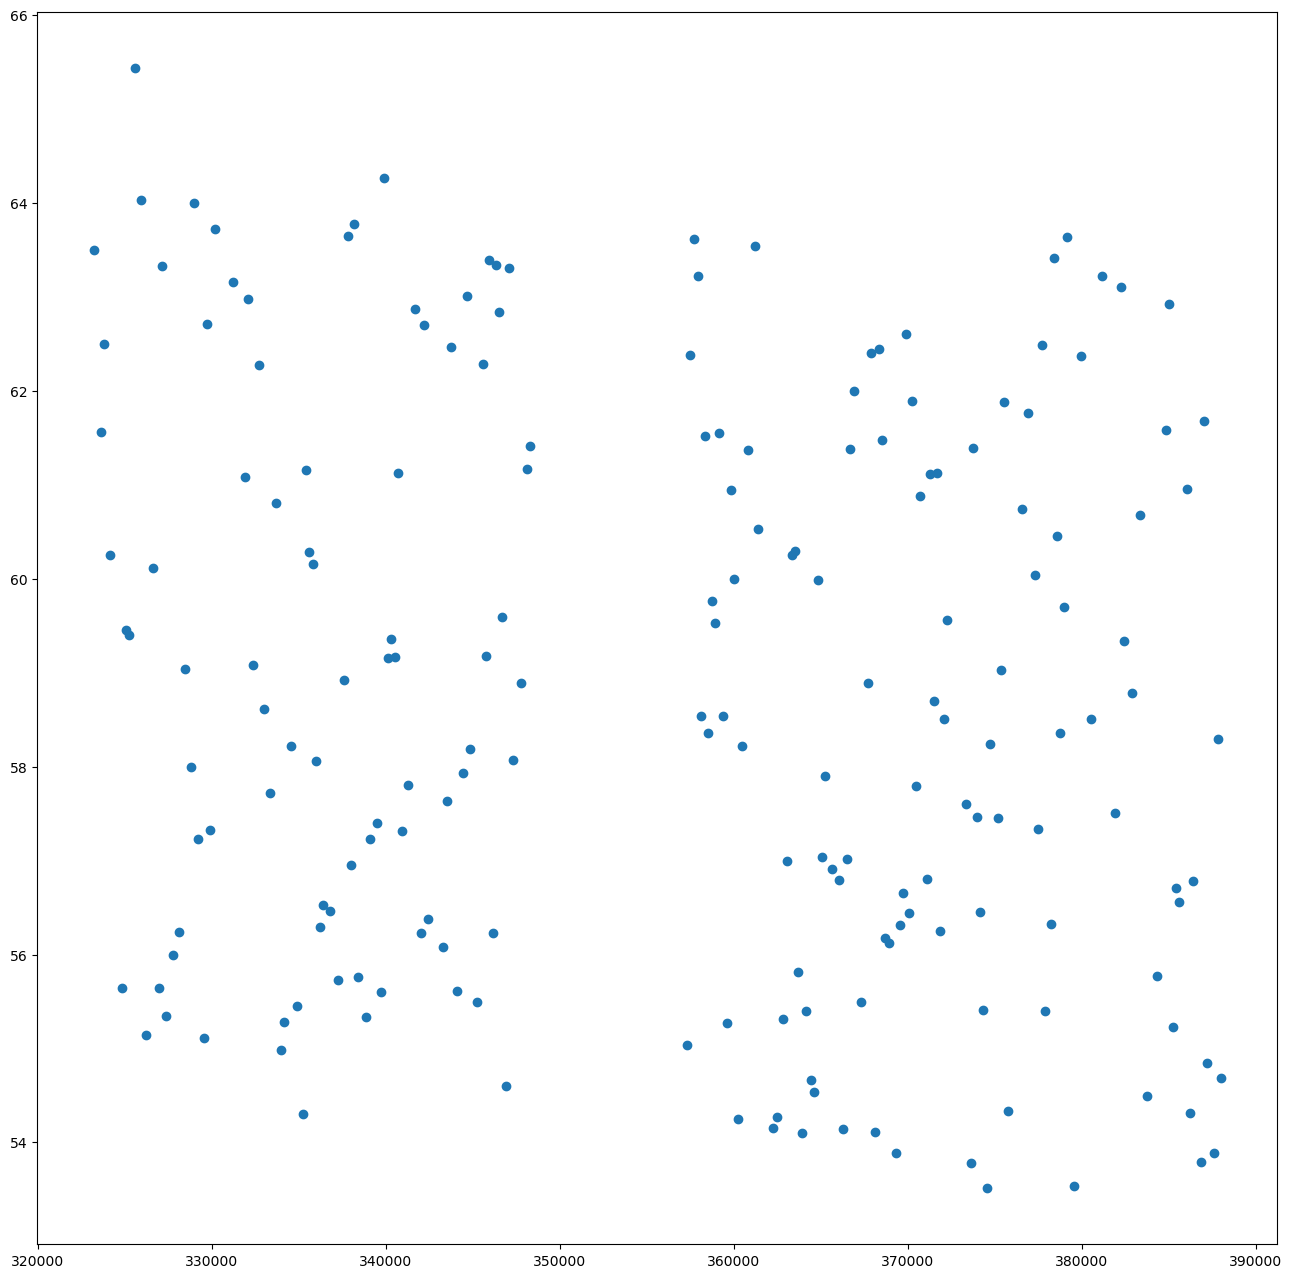

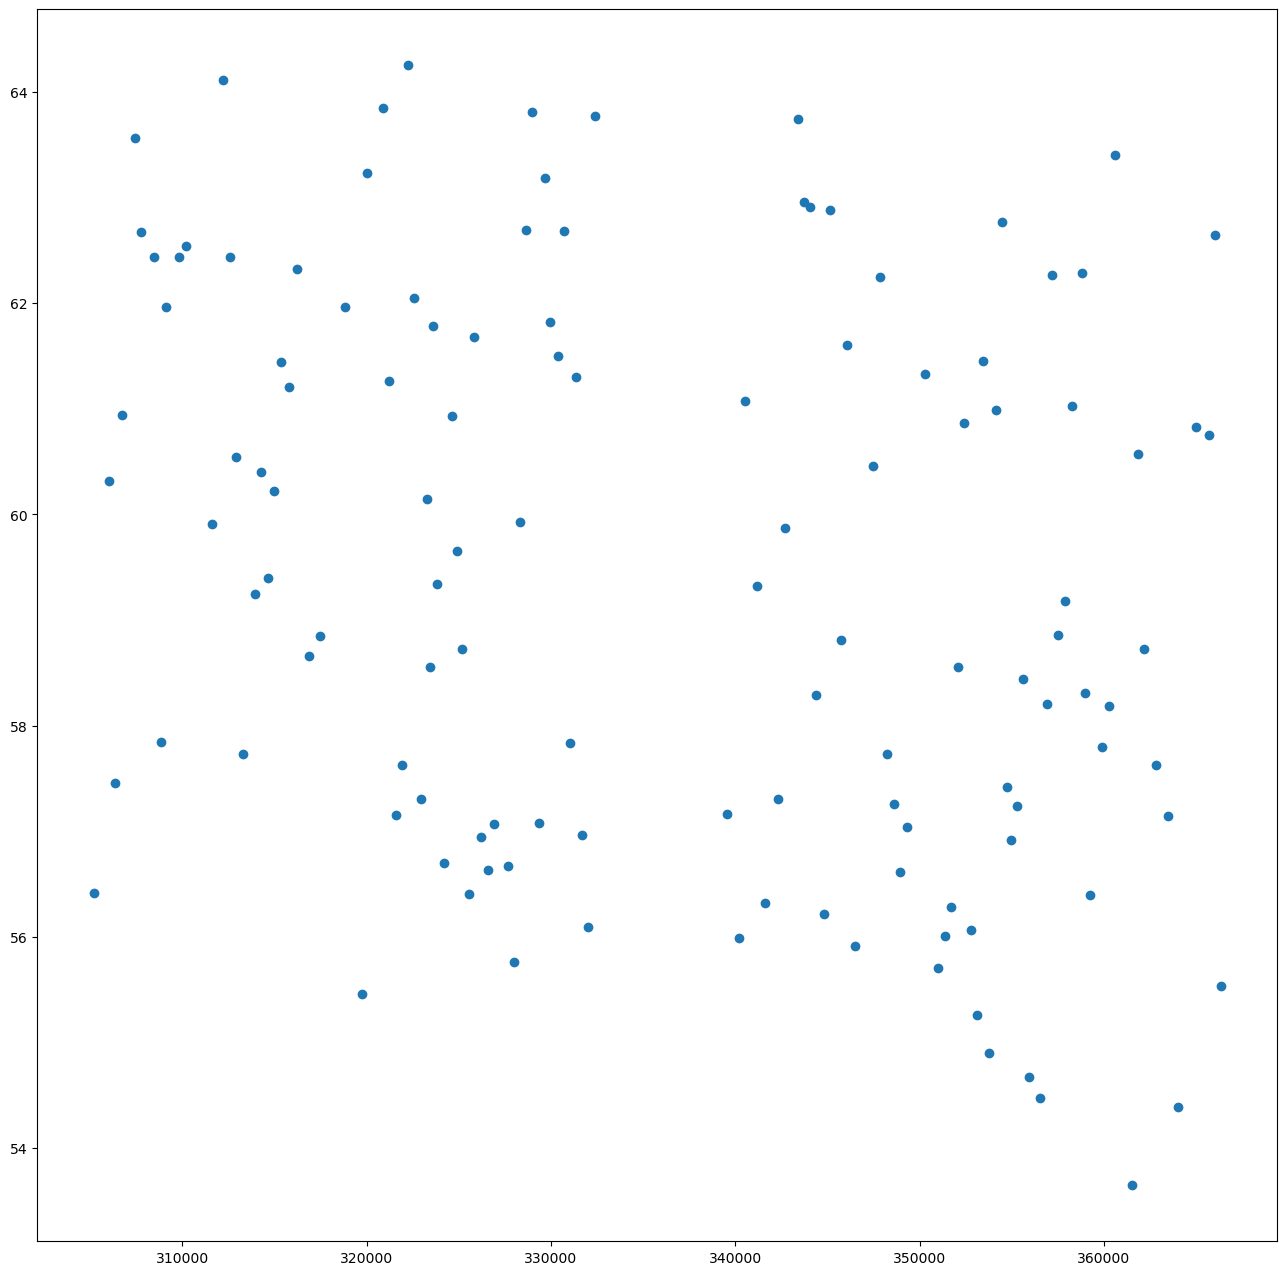

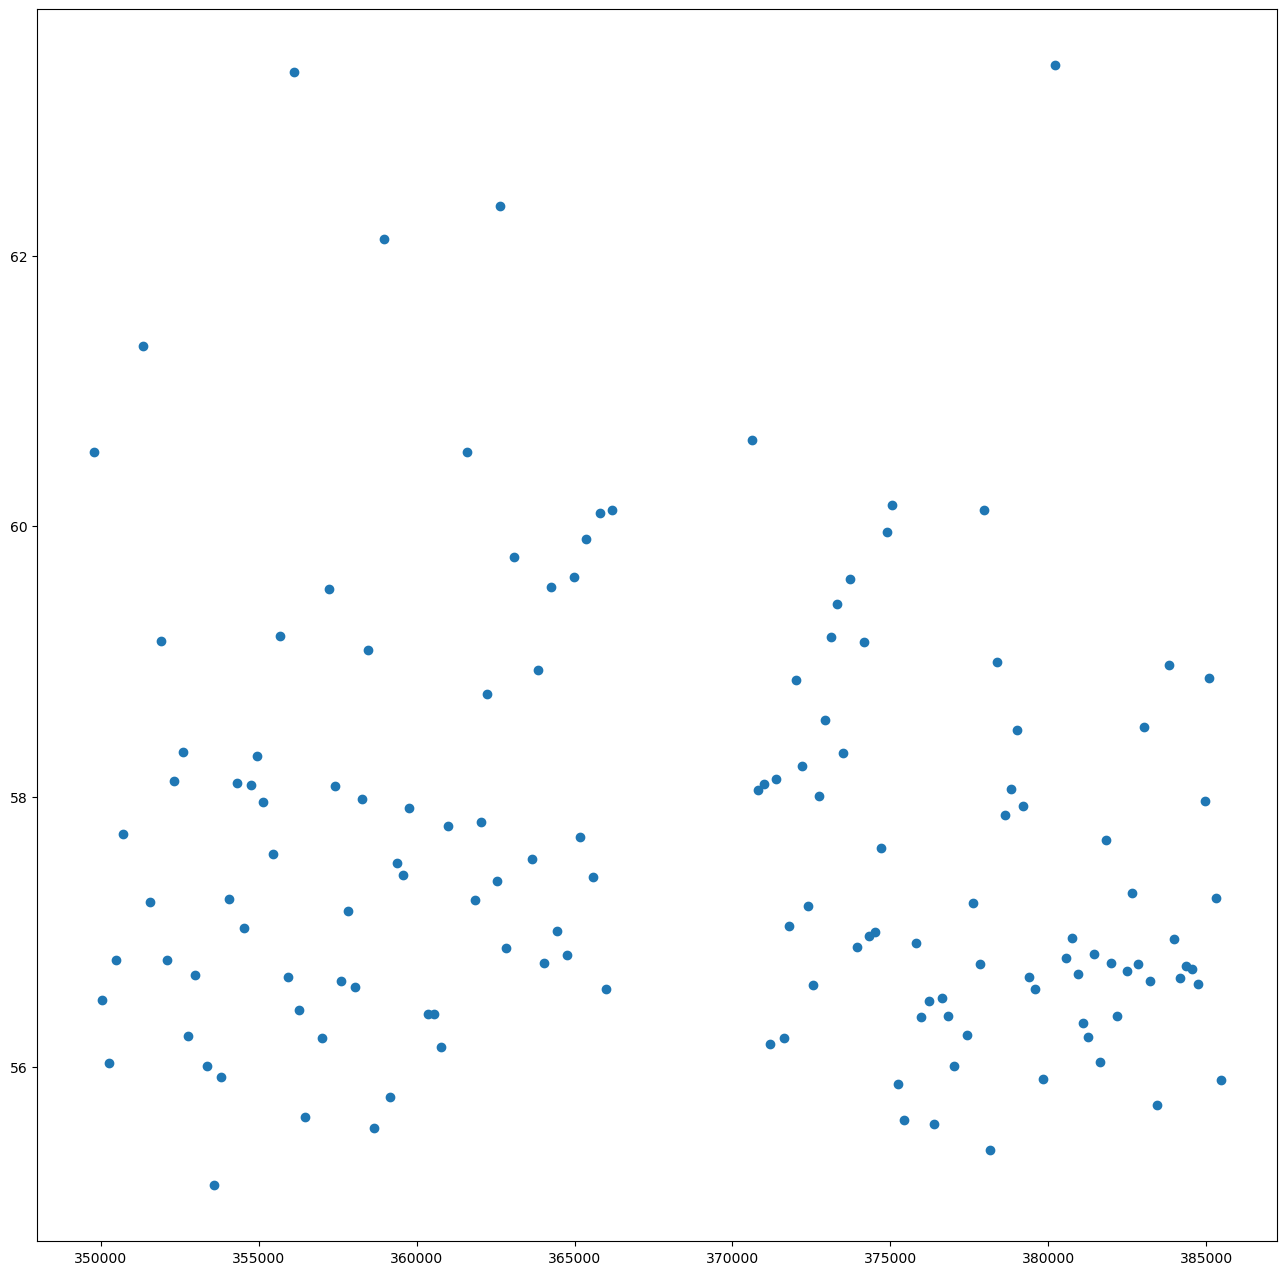

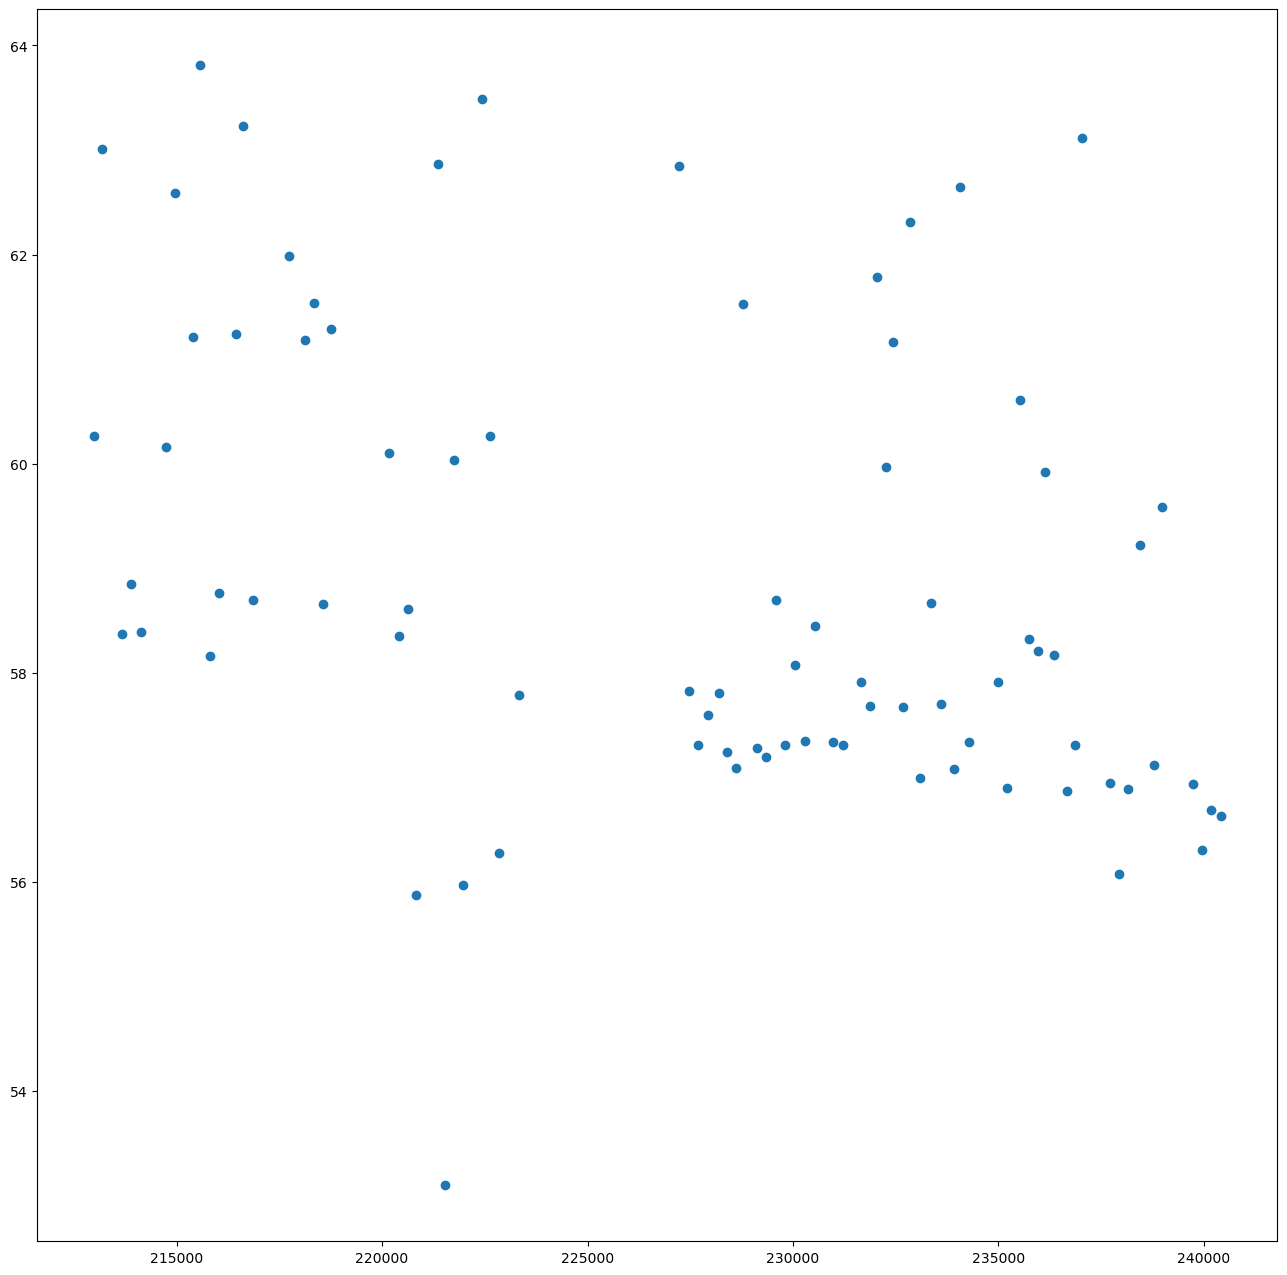

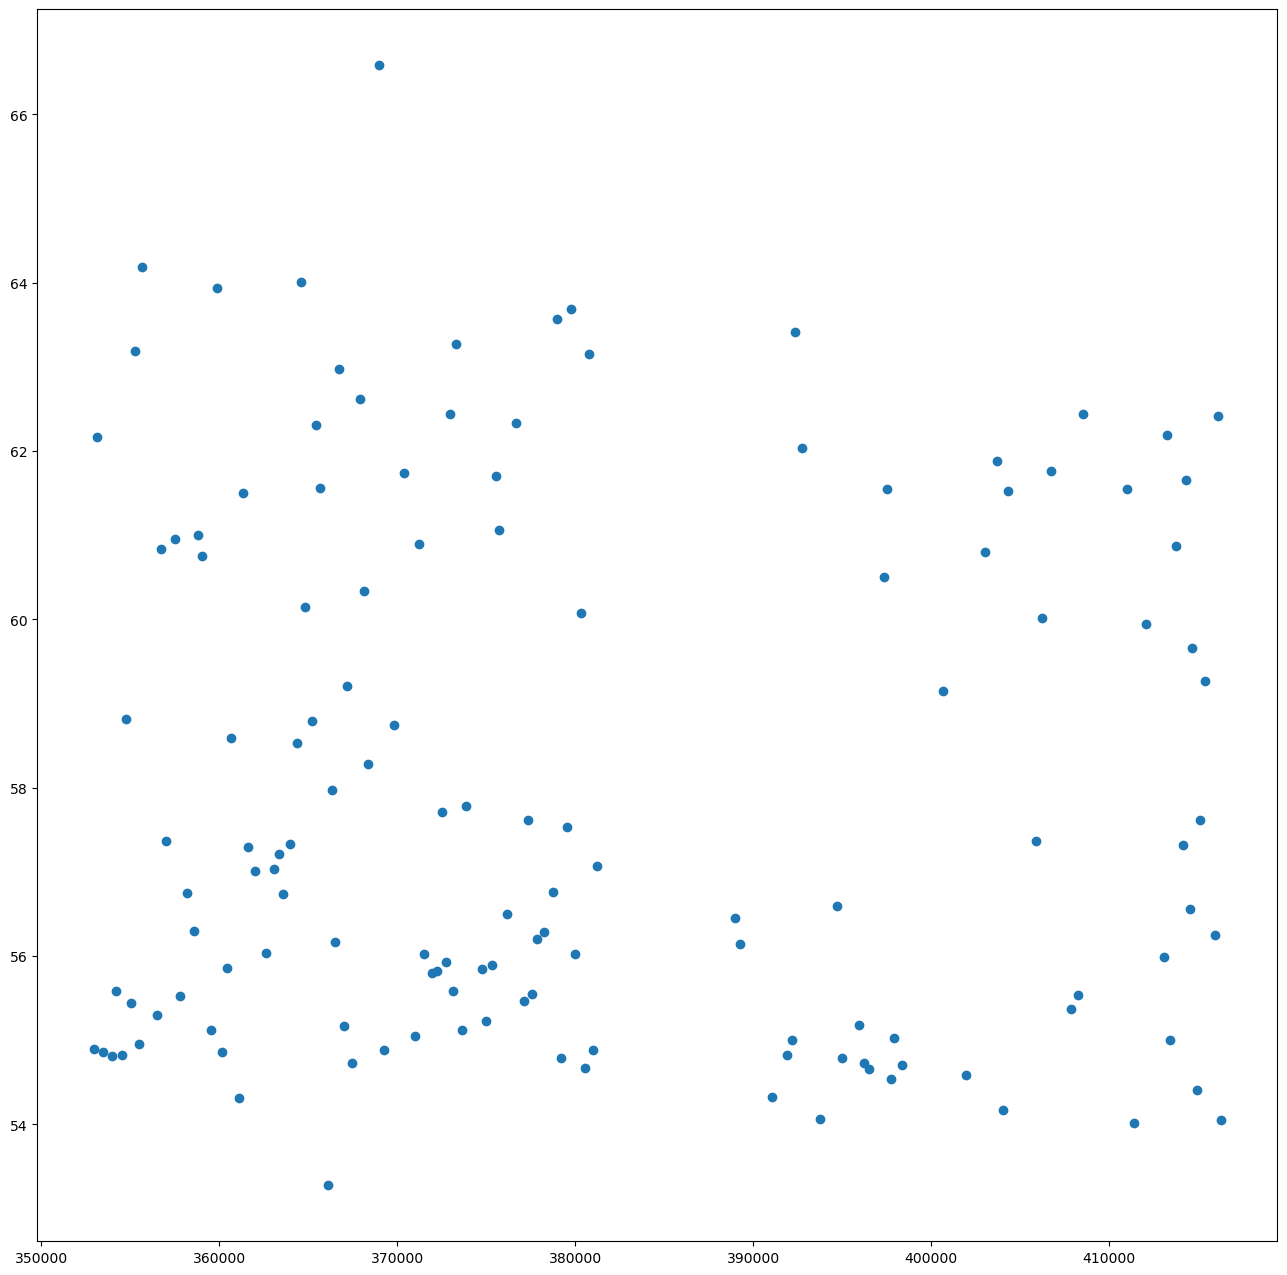

In [17]:
for car_id, data in data_dict.items():
        #设置循环标记
        end_mask = (data['charge_status'].shift(2) == 1) & (data['charge_status'].shift(1) == 1) & (data['charge_status'] == 3)& (data['charge_status'].shift(-1) == 3)
        begin_mask = (data['charge_status'].shift(2) == 3) & (data['charge_status'].shift(1) == 3) & (data['charge_status'] == 1)& (data['charge_status'].shift(-1) == 1)
        data['cycle_flag'] = end_mask.cumsum()
        data['begin_charge_flag'] = begin_mask
        ## 绘制data内所有特征的曲线图
        # from matplotlib import pyplot as plt
        # data.plot(subplots=True, figsize=(16, 16))
        # plt.savefig('data/{}_data.png'.format(car_id))

        feature_data = pd.DataFrame(columns=feature_columns)
        charge_list = []
        mileage_list = []
        # 对每个充放电循环进行处理
        groups = data.groupby(data['cycle_flag'])
        for group, frame in groups:
            frame = frame.sort_index()
            charge_data = frame[frame['charge_status'] == 1]
            begin_charge_row = frame[frame['begin_charge_flag']==1]
            if charge_data.empty or begin_charge_row.empty:
                continue
            mileage = begin_charge_row['mileage'].values[0]
            ##判断soc是否是连续上升的序列，前后相差1
            soc_charge = charge_data['soc']          
            soc_charge_max = charge_data['soc'].max()
            soc_charge_min = charge_data['soc'].min()
            ##判断charge_data_diff是不是只有1

            soc_change_max =charge_data['soc'].diff().abs().max()
            #确保soc_chargehe soc_change_max的值不为空且长度为1
            if soc_charge_max>=90 and soc_charge_min <= 40 and soc_change_max <= 1:
                #选择charge_data中soc在40和90之间的数据
                charge_data = charge_data[(charge_data['soc']>=40) & (charge_data['soc']<=90)]
                charge_data_filtered = charge_data[charge_data.diff().sum(axis=1) != 0]
                charge_energy = abs(1/180 *charge_data_filtered['total_current'].sum())
                frame['charge_energy'] = charge_energy
                feature_data = feature_data.append(frame)
            else:
                continue
            #绘制每个循环的曲线图
            charge_list.append(charge_energy)
            mileage_list.append(mileage)
            # frame.plot(subplots=True, figsize=(16, 16))
            # plt.savefig('data/{}_{}_data.png'.format(car_id, group))

            # print("车辆{}，循环{}中充电状态为:{}".format(car_id, group, charge_energy))
        #绘制每个车辆的充电能量和里程数的散点图
        plt.figure(figsize=(16, 16))
        plt.scatter(mileage_list,charge_list)
        print("车辆{}，充电能量为:{}".format(car_id, charge_list))
        plt.savefig('data/{}_charge_mileage.png'.format(car_id))